## Readme

Necessary Packages to install:
- pandas
- pytorch
- transformers
- scikit-learn
- matplotlib
- openai

Necessary Files:
- gender-classifier-DFE-791531.csv (twitter dataset)
- generated_tweets_chatgpt.csv (synthetic dataset)

In [1]:
import pandas as pd
import torch
import os
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
pip uninstall torch torchvision -y

Found existing installation: torch 2.5.1+cu118
Uninstalling torch-2.5.1+cu118:
  Successfully uninstalled torch-2.5.1+cu118
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124


In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu124
    Uninstalling torchaudio-2.5.1+cu124:
      Successfully uninstalled torchaudio-2.5.1+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path_to_dir = "./"
#path_to_dir = "/content/drive/MyDrive/Fourth Year/Winter 2025/NLP Project/"
# change path_to_dir for each person. this robert's personal path
twitter_gender_dataset = pd.read_csv(f"{path_to_dir}gender-classifier-DFE-791531.csv", encoding="latin1")

In [ ]:
#OJ Path
path_to_dir = "/content/drive/MyDrive/nlp/NLP Project/"
twitter_gender_dataset = pd.read_csv(f"{path_to_dir}gender-classifier-DFE-791531.csv", encoding="latin1")

In [4]:
twitter_gender_dataset_preprocessed = twitter_gender_dataset[twitter_gender_dataset['gender:confidence'] == 1]
twitter_gender_dataset_preprocessed = twitter_gender_dataset_preprocessed[twitter_gender_dataset_preprocessed['profile_yn:confidence'] == 1]
twitter_gender_dataset_preprocessed = twitter_gender_dataset_preprocessed[twitter_gender_dataset_preprocessed['profile_yn'] == 'yes']
twitter_gender_dataset_preprocessed = twitter_gender_dataset_preprocessed[twitter_gender_dataset_preprocessed['gender'].isin(['male', 'female', 'brand'])]
twitter_gender_dataset_preprocessed.drop(['_golden', '_unit_state' , '_trusted_judgments', '_last_judgment_at', 'profileimage','gender:confidence', 'profile_yn:confidence', 'profile_yn', 'gender_gold', 'link_color', 'tweet_coord', 'profile_yn_gold', 'sidebar_color'], axis=1, inplace=True)

In [5]:
twitter_gender_dataset_preprocessed.shape

(13804, 13)

In [6]:
twitter_gender_dataset_preprocessed['gender'].value_counts()

gender
female    5367
male      4653
brand     3784
Name: count, dtype: int64

In [7]:
twitter_gender_dataset_preprocessed.head()

,_unit_id,gender,created,description,fav_number,name,retweet_count,text,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,male,12/5/13 1:48,i sing my own rhythm.,0,sheezy0,0,Robbie E Responds To Critics After Win Against...,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,male,10/1/12 13:51,I'm the author of novels filled with family dr...,68,DavdBurnett,0,ÛÏIt felt like they were my friends and I was...,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
3,815719229,male,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,douggarland,0,Hi @JordanSpieth - Looking at the url - do you...,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,female,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,WilfordGemma,0,Watching Neighbours on Sky+ catching up with t...,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
5,815719231,female,3/11/10 18:14,you don't know me.,3901,monroevicious,0,"Ive seen people on the train with lamps, chair...",20036,10/26/15 12:40,6.587300e+17,New York Gritty,Central Time (US & Canada)


In [9]:
training_cutoff = 5000
testing_cutoff = 7500
train_dataset_range = (0, training_cutoff) # increase this value when training on more data
test_dataset_range = (train_dataset_range[1] + 1, testing_cutoff)
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

# Base Model (Bert Trained)

In [10]:
smaller_dataset = twitter_gender_dataset_preprocessed[:train_dataset_range[1]]
texts = smaller_dataset['text'].tolist()
labels = smaller_dataset['gender'].tolist()

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [12]:
label_map = {"male": 0, "female": 1, "brand": 2}

In [13]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128, label_map=label_map):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = label_map

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        numeric_label = self.label_map[label]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(numeric_label, dtype=torch.long)
        }

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))

train_dataset = TweetDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, max_len=128)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def train_model(model, train_dataloader, val_dataloader, epochs=EPOCHS, learning_rate=LEARNING_RATE):
  """Trains a PyTorch model using the provided data loaders.

  Args:
      model: The PyTorch model to train.
      train_dataloader: A PyTorch DataLoader for the training data.
      val_dataloader: A PyTorch DataLoader for the validation data.
      epochs: The number of training epochs. Defaults to `EPOCHS`.
      learning_rate: The learning rate for the optimizer. Defaults to `LEARNING_RATE`.

  Returns:
      None. The function modifies the model in-place.
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
  epochs = EPOCHS
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  for epoch in range(epochs):
      model.train()
      total_train_loss = 0
      for batch in train_dataloader:
          optimizer.zero_grad()

          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels_batch = batch["labels"].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
          loss = outputs.loss
          total_train_loss += loss.item()

          loss.backward()
          optimizer.step()
          scheduler.step()

      avg_train_loss = total_train_loss / len(train_dataloader)
      print(f"Epoch {epoch+1}/{epochs} - Average Training Loss: {avg_train_loss:.4f}")

      model.eval()
      predictions = []
      true_labels = []
      with torch.no_grad():
          for batch in val_dataloader:
              input_ids = batch["input_ids"].to(device)
              attention_mask = batch["attention_mask"].to(device)
              labels_batch = batch["labels"].to(device)

              outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
              logits = outputs.logits
              preds = torch.argmax(logits, dim=1)

              predictions.extend(preds.cpu().numpy())
              true_labels.extend(labels_batch.cpu().numpy())

      accuracy = accuracy_score(true_labels, predictions)
      report = classification_report(true_labels, predictions, target_names=["male", "female", "brand"])

      print("Accuracy:", accuracy)
      print("Classification Report:\n", report)

  return accuracy, report

In [16]:
def write_accuracy_report(name, accuracy, report):
    f = open(f"{path_to_dir}charts_no_fake_tweets.txt", "a")
    f.write(name + "\n")
    f.write("Accuracy: " + str(accuracy) + "\n")
    f.write("Report: " + str(report) + "\n")
    f.write("-------------\n")
    f.close()

In [17]:
accuracy_base, report_base = train_model(model, train_dataloader, val_dataloader)
write_accuracy_report("Base Model IS", accuracy_base, report_base)

/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 1.0739


/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.379
Classification Report:
               precision    recall  f1-score   support

        male       0.35      1.00      0.52       332
      female       0.00      0.00      0.00       371
       brand       1.00      0.16      0.27       297

    accuracy                           0.38      1000
   macro avg       0.45      0.39      0.26      1000
weighted avg       0.41      0.38      0.25      1000

Epoch 2/10 - Average Training Loss: 0.9663
Accuracy: 0.504
Classification Report:
               precision    recall  f1-score   support

        male       0.34      0.22      0.27       332
      female       0.47      0.53      0.49       371
       brand       0.64      0.80      0.71       297

    accuracy                           0.50      1000
   macro avg       0.48      0.51      0.49      1000
weighted avg       0.48      0.50      0.48      1000

Epoch 3/10 - Average Training Loss: 0.9347
Accuracy: 0.533
Classification Report:
               precision    recal

In [18]:
smaller_dataset_test = twitter_gender_dataset_preprocessed[test_dataset_range[0]:test_dataset_range[1]]

In [19]:
test_texts = smaller_dataset_test['text'].tolist()
true_labels = smaller_dataset_test['gender'].tolist()
true_labels = [label_map[label] for label in true_labels]

In [20]:
def test_model(model, test_texts, true_labels):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  encoded_inputs = tokenizer(
    test_texts,
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
  )
  encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
  model.eval()
  with torch.no_grad():
      outputs = model(**encoded_inputs)
      logits = outputs.logits
  predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
  accuracy = accuracy_score(true_labels, predicted_labels)
  report = classification_report(true_labels, predicted_labels, target_names=["male", "female", "brand"])

  print("Accuracy:", accuracy)
  print("Classification Report:\n", report)
  return predicted_labels, accuracy, report

In [21]:
predicted_labels, accuracy, report = test_model(model, test_texts, true_labels)
write_accuracy_report("Base Model OOS", accuracy, report)

Accuracy: 0.5798319327731093
Classification Report:
               precision    recall  f1-score   support

        male       0.41      0.48      0.45       777
      female       0.58      0.53      0.56       867
       brand       0.77      0.72      0.74       855

    accuracy                           0.58      2499
   macro avg       0.59      0.58      0.58      2499
weighted avg       0.59      0.58      0.58      2499



# Adding Metadata

Metadata used: name ('name'), profile bio ('description'), location ('tweet_location')

In [22]:
twitter_gender_dataset_metadata = twitter_gender_dataset_preprocessed.copy()
metadata = {'profile': twitter_gender_dataset_metadata['description']}
twitter_gender_dataset_metadata['text_all_metadata'] = 'name:' + twitter_gender_dataset_metadata['name'].fillna('') + ' tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' profile:' + twitter_gender_dataset_metadata['description'].fillna('') + ' location:' + twitter_gender_dataset_metadata['tweet_location'].fillna('')
twitter_gender_dataset_metadata['text_name'] = 'name:' + twitter_gender_dataset_metadata['name'].fillna('') + ' tweet:' + twitter_gender_dataset_metadata['text'].fillna('')
twitter_gender_dataset_metadata['text_description'] = 'tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' profile:' + twitter_gender_dataset_metadata['description'].fillna('')
twitter_gender_dataset_metadata['text_name_description'] = 'name:' + twitter_gender_dataset_metadata['name'].fillna('') + ' tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' profile:' + twitter_gender_dataset_metadata['description'].fillna('')
twitter_gender_dataset_metadata['text_location'] = 'tweet:' + twitter_gender_dataset_metadata['text'].fillna('') + ' location:' + twitter_gender_dataset_metadata['tweet_location'].fillna('')

twitter_gender_dataset_metadata.head()

,_unit_id,gender,created,description,fav_number,name,retweet_count,text,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone,text_all_metadata,text_name,text_description,text_name_description,text_location
0,815719226,male,12/5/13 1:48,i sing my own rhythm.,0,sheezy0,0,Robbie E Responds To Critics After Win Against...,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai,name:sheezy0 tweet:Robbie E Responds To Critic...,name:sheezy0 tweet:Robbie E Responds To Critic...,tweet:Robbie E Responds To Critics After Win A...,name:sheezy0 tweet:Robbie E Responds To Critic...,tweet:Robbie E Responds To Critics After Win A...
1,815719227,male,10/1/12 13:51,I'm the author of novels filled with family dr...,68,DavdBurnett,0,ÛÏIt felt like they were my friends and I was...,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada),name:DavdBurnett tweet:ÛÏIt felt like they we...,name:DavdBurnett tweet:ÛÏIt felt like they we...,tweet:ÛÏIt felt like they were my friends and...,name:DavdBurnett tweet:ÛÏIt felt like they we...,tweet:ÛÏIt felt like they were my friends and...
3,815719229,male,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,douggarland,0,Hi @JordanSpieth - Looking at the url - do you...,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada),name:douggarland tweet:Hi @JordanSpieth - Look...,name:douggarland tweet:Hi @JordanSpieth - Look...,tweet:Hi @JordanSpieth - Looking at the url - ...,name:douggarland tweet:Hi @JordanSpieth - Look...,tweet:Hi @JordanSpieth - Looking at the url - ...
4,815719230,female,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,WilfordGemma,0,Watching Neighbours on Sky+ catching up with t...,31462,10/26/15 12:40,6.587300e+17,NaN,NaN,name:WilfordGemma tweet:Watching Neighbours on...,name:WilfordGemma tweet:Watching Neighbours on...,tweet:Watching Neighbours on Sky+ catching up ...,name:WilfordGemma tweet:Watching Neighbours on...,tweet:Watching Neighbours on Sky+ catching up ...
5,815719231,female,3/11/10 18:14,you don't know me.,3901,monroevicious,0,"Ive seen people on the train with lamps, chair...",20036,10/26/15 12:40,6.587300e+17,New York Gritty,Central Time (US & Canada),name:monroevicious tweet:Ive seen people on th...,name:monroevicious tweet:Ive seen people on th...,"tweet:Ive seen people on the train with lamps,...",name:monroevicious tweet:Ive seen people on th...,"tweet:Ive seen people on the train with lamps,..."


In [23]:
smaller_dataset_metadata = twitter_gender_dataset_metadata[:train_dataset_range[1]]
text_all_metadata = smaller_dataset_metadata['text_all_metadata'].tolist()
text_name = smaller_dataset_metadata['text_name'].tolist()
text_description = smaller_dataset_metadata['text_description'].tolist()
text_name_description = smaller_dataset_metadata['text_name_description'].tolist()
text_location = smaller_dataset_metadata['text_location'].tolist()
labels_metadata = smaller_dataset_metadata['gender'].tolist()

In [24]:
def train_model_full(texts, labels):
  train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
  )
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_map))

  train_dataset = TweetDataset(train_texts, train_labels, tokenizer, max_len=128)
  val_dataset = TweetDataset(val_texts, val_labels, tokenizer, max_len=128)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
  accuracy, report = train_model(model, train_dataloader, val_dataloader)
  return model, accuracy, report

In [25]:
model_all_metadata, accuracy, report = train_model_full(text_all_metadata, labels_metadata)
write_accuracy_report("All Metadata IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.6827
Accuracy: 0.757
Classification Report:
               precision    recall  f1-score   support

        male       0.63      0.85      0.72       332
      female       0.87      0.55      0.68       371
       brand       0.86      0.91      0.88       297

    accuracy                           0.76      1000
   macro avg       0.79      0.77      0.76      1000
weighted avg       0.79      0.76      0.75      1000

Epoch 2/10 - Average Training Loss: 0.3740
Accuracy: 0.775
Classification Report:
               precision    recall  f1-score   support

        male       0.64      0.83      0.73       332
      female       0.81      0.66      0.73       371
       brand       0.94      0.86      0.89       297

    accuracy                           0.78      1000
   macro avg       0.80      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000

Epoch 3/10 - Average Training Loss: 0.2028
Accuracy: 0.788
Classificatio

In [26]:
model_name, accuracy, report = train_model_full(text_name, labels_metadata)
write_accuracy_report("Name IS", accuracy, report)
model_description, accuracy, report  = train_model_full(text_description, labels_metadata)
write_accuracy_report("Bio IS", accuracy, report)
model_name_description, accuracy, report  = train_model_full(text_name_description, labels_metadata)
write_accuracy_report("Name and Bio IS", accuracy, report)
model_location, accuracy, report  = train_model_full(text_location, labels_metadata)
write_accuracy_report("Location IS", accuracy, report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.8924
Accuracy: 0.696
Classification Report:
               precision    recall  f1-score   support

        male       0.60      0.68      0.64       332
      female       0.76      0.62      0.68       371
       brand       0.75      0.80      0.77       297

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000

Epoch 2/10 - Average Training Loss: 0.5940
Accuracy: 0.726
Classification Report:
               precision    recall  f1-score   support

        male       0.63      0.78      0.70       332
      female       0.74      0.67      0.70       371
       brand       0.85      0.74      0.79       297

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000

Epoch 3/10 - Average Training Loss: 0.3705
Accuracy: 0.736
Classificatio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.7347
Accuracy: 0.708
Classification Report:
               precision    recall  f1-score   support

        male       0.71      0.44      0.54       332
      female       0.61      0.82      0.70       371
       brand       0.88      0.86      0.87       297

    accuracy                           0.71      1000
   macro avg       0.73      0.71      0.70      1000
weighted avg       0.72      0.71      0.70      1000

Epoch 2/10 - Average Training Loss: 0.4594
Accuracy: 0.716
Classification Report:
               precision    recall  f1-score   support

        male       0.62      0.65      0.63       332
      female       0.67      0.66      0.66       371
       brand       0.90      0.86      0.88       297

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.73      1000
weighted avg       0.72      0.72      0.72      1000

Epoch 3/10 - Average Training Loss: 0.2189
Accuracy: 0.708
Classificatio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.8908
Accuracy: 0.636
Classification Report:
               precision    recall  f1-score   support

        male       0.49      0.52      0.50       332
      female       0.60      0.58      0.59       371
       brand       0.86      0.83      0.84       297

    accuracy                           0.64      1000
   macro avg       0.65      0.64      0.65      1000
weighted avg       0.64      0.64      0.64      1000

Epoch 2/10 - Average Training Loss: 0.6506
Accuracy: 0.764
Classification Report:
               precision    recall  f1-score   support

        male       0.74      0.65      0.69       332
      female       0.76      0.75      0.76       371
       brand       0.79      0.91      0.84       297

    accuracy                           0.76      1000
   macro avg       0.76      0.77      0.76      1000
weighted avg       0.76      0.76      0.76      1000

Epoch 3/10 - Average Training Loss: 0.4583
Accuracy: 0.783
Classificatio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/robertwang/Downloads/NLP/.venv/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Average Training Loss: 0.9262
Accuracy: 0.589
Classification Report:
               precision    recall  f1-score   support

        male       0.63      0.30      0.41       332
      female       0.61      0.58      0.59       371
       brand       0.56      0.92      0.70       297

    accuracy                           0.59      1000
   macro avg       0.60      0.60      0.57      1000
weighted avg       0.60      0.59      0.56      1000

Epoch 2/10 - Average Training Loss: 0.7833
Accuracy: 0.613
Classification Report:
               precision    recall  f1-score   support

        male       0.52      0.48      0.50       332
      female       0.61      0.67      0.64       371
       brand       0.73      0.68      0.70       297

    accuracy                           0.61      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.61      0.61      0.61      1000

Epoch 3/10 - Average Training Loss: 0.5551
Accuracy: 0.624
Classificatio

In [27]:
smaller_dataset_test = twitter_gender_dataset_metadata[test_dataset_range[0]:test_dataset_range[1]]

test_texts_all_metadta = smaller_dataset_test['text_all_metadata'].tolist()
test_texts_name = smaller_dataset_test['text_name'].tolist()
test_texts_description = smaller_dataset_test['text_description'].tolist()
test_texts_name_description = smaller_dataset_test['text_name_description'].tolist()
test_texts_location = smaller_dataset_test['text_location'].tolist()

true_labels = smaller_dataset_test['gender'].tolist()
true_labels = [label_map[label] for label in true_labels]
test_texts = [str(text) for text in test_texts]

In [28]:
print("All Metadata:")
predicted_outputs_all_metadata, all_metadata_accuracy, all_metadata_report = test_model(model_all_metadata, test_texts, true_labels)
write_accuracy_report("All Metadata OOS", all_metadata_accuracy, all_metadata_report)

All Metadata:
Accuracy: 0.6066426570628252
Classification Report:
               precision    recall  f1-score   support

        male       0.50      0.50      0.50       777
      female       0.61      0.53      0.56       867
       brand       0.69      0.79      0.73       855

    accuracy                           0.61      2499
   macro avg       0.60      0.60      0.60      2499
weighted avg       0.60      0.61      0.60      2499



In [29]:

print("Just name:")
predicted_outputs_name, accuracy, report = test_model(model_name, test_texts_name, true_labels)
write_accuracy_report("Name OOS", accuracy, report)
print("Just bio:")
predicted_outputs_description = test_model(model_description, test_texts_description, true_labels)
write_accuracy_report("Bio OOS", accuracy, report)
print("Bio and Name:")
predicted_outputs_name_description = test_model(model_name_description, test_texts_name_description, true_labels)
write_accuracy_report("Name and Bio OOS", accuracy, report)
print("Just location:")
predicted_outputs_location = test_model(model_location, test_texts_location, true_labels)
write_accuracy_report("Location OOS", accuracy, report)

Just name:
Accuracy: 0.7406962785114045
Classification Report:
               precision    recall  f1-score   support

        male       0.65      0.71      0.68       777
      female       0.73      0.75      0.74       867
       brand       0.85      0.76      0.81       855

    accuracy                           0.74      2499
   macro avg       0.74      0.74      0.74      2499
weighted avg       0.75      0.74      0.74      2499

Just bio:
Accuracy: 0.7599039615846338
Classification Report:
               precision    recall  f1-score   support

        male       0.66      0.69      0.67       777
      female       0.72      0.70      0.71       867
       brand       0.90      0.88      0.89       855

    accuracy                           0.76      2499
   macro avg       0.76      0.76      0.76      2499
weighted avg       0.76      0.76      0.76      2499

Bio and Name:
Accuracy: 0.8115246098439376
Classification Report:
               precision    recall  f1-score 

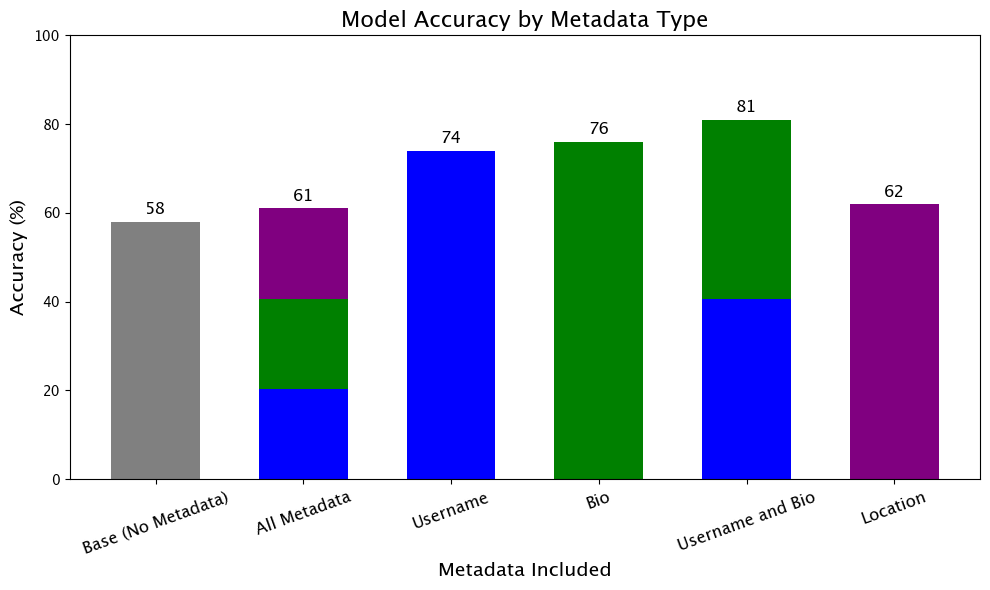

In [8]:
import matplotlib.pyplot as plt
import numpy as np

accuracy_scores = {
    "Base (No Metadata)": 58,
    "All Metadata": 61,
    "Username": 74,
    "Bio": 76,
    "Username and Bio": 81,
    "Location": 62
}

metadata_components = {
    "Base (No Metadata)": [],
    "All Metadata": ["Username", "Bio", "Location"],
    "Username": ["Username"],
    "Bio": ["Bio"],
    "Username and Bio": ["Username", "Bio"],
    "Location": ["Location"]
}

component_colors = {
    "Username": "blue",
    "Bio": "green",
    "Location": "purple",
    "Baseline": "grey"
}

x = np.arange(len(accuracy_scores))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))

for i, (label, acc) in enumerate(accuracy_scores.items()):
    bottom = 0
    if metadata_components[label]:
        num_components = len(metadata_components[label])
        segment_height = acc / num_components
        for component in metadata_components[label]:
            ax.bar(x[i], segment_height, width, bottom=bottom, 
                   label=component if i == 0 else "", 
                   color=component_colors[component])
            bottom += segment_height
    else:
        ax.bar(x[i], acc, width, color=component_colors["Baseline"], 
               label="Baseline" if i == 0 else "")
        bottom = acc
    
    ax.text(x[i], bottom + 1, f'{acc}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel("Metadata Included", fontsize=14, fontweight='bold')
ax.set_ylabel("Accuracy (%)", fontsize=14, fontweight='bold')
ax.set_title("Model Accuracy by Metadata Type", fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_scores.keys(), rotation=20, fontsize=12)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()
